## Resume Parser 

### 1. Data Gathering and Processing

To create a diverse and representative dataset for this project, I gathered a small set of **7 synthetic resumes** in both PDF and Word formats. This approach ensures the solution is not overfitted to any specific resume style and can handle variations in document structure. This small sample will also be used for evaluating the project's performance.

The resume samples were sourced from the following platforms:

* **Indeed Resume Builder** ([www.resume.com](https://www.resume.com)): I created and downloaded **3 resumes in PDF format** using this free tool. The profile information (names, emails, and skills) was generated using an AI tool (Gemini 2.5 Flash) to ensure the data was fictitious and unique to this project.
* **Microsoft 365 Resume Templates** ([create.microsoft.com/en-us/templates/resumes](https://create.microsoft.com/en-us/templates/resumes)): To obtain samples in the **Word (.docx) format**, I utilized the free resume template bank provided by Microsoft. I created and downloaded **4 resumes in .docx format**. These templates cover a range of professional layouts and designs, which helps in testing the robustness of the parsing algorithm across different document structures.

By using these methods, I was able to create a small but effective dataset to develop and evaluate the resume parser.

### 2. Proof of Concept (POC) and System Design

The development of this resume parser will follow a **Test-Driven Development (TDD)** approach. This means we will start by writing tests that specify the expected behavior of our solution. These tests will serve as our development roadmap, ensuring that our code correctly handles the required inputs and produces the desired structured output.

---

#### 2.1. Overall System Pipeline

The core of this project is a robust pipeline designed to extract structured information from various resume file formats. The proposed system design is a multi-step process that leverages specialized libraries for document conversion and the power of a large language model (LLM) for intelligent information extraction.

The high-level pipeline can be summarized as follows:

1.  **TDD Driver**: The development begins with test cases written in `pytest`, which define the expected `name`, `email`, and `skills` for our sample resumes.
2.  **Document Ingestion**: The system accepts resumes in either PDF or Word (.docx) format.
3.  **Document-to-Markdown Conversion**: Both file types are converted into a standardized Markdown format. This is a critical step, as Markdown preserves key structural elements (like headings, lists, and bold text) while creating a clean, text-based representation. This format is also ideal for processing by LLMs, as they are often pre-trained on a vast corpus of Markdown text, leading to more predictable and accurate results.
4.  **LLM-based Information Extraction**: The Markdown text of the resume is passed to a powerful LLM with a carefully crafted prompt. The prompt directs the LLM to identify and extract the candidate's name, email, and skills.
5.  **Structured Output Generation**: The LLM is configured to return the extracted information in a structured JSON format, ensuring a clean and consistent output.
6.  **Output Validation**: The final JSON object is validated against a defined schema, and the test cases verify that the output matches the ground truth.

---

#### 2.2. Technical Stack and Tooling

To implement this pipeline, I propose using a specific set of tools and packages for each step, balancing efficiency, cost, and maintainability.

**Testing:**

* The project will be **test-driven using `pytest`**. Tests will be written to fail initially, guiding the implementation of the parsing logic until they pass. This ensures all functionality is verified and provides a safety net for future refactoring.

**Document Conversion:**

* **Word (.docx) to Markdown**: The `markdown-it-doc` package is the primary choice for its reliability in converting Microsoft Word documents to Markdown. As a fallback, `pandoc` can be used, a versatile command-line tool known for its extensive support for various document conversions.
* **PDF to Markdown**: For PDF parsing, `pymupdf4llm` will be leveraged. This library is specifically designed to handle the complexities of PDF layouts and produce LLM-friendly output. It provides a more robust solution compared to general-purpose PDF-to-text libraries. A simple fallback would be `PyMuPDF`, which offers basic text extraction capabilities.

**LLM and Prompt Engineering:**

* **LLM Service**: The API from [OpenRouter](https://openrouter.ai/) will be used to access various LLMs, prioritizing **`Gpt4-mini`** due to its low cost and strong performance. This choice balances accuracy with cost-effectiveness.
* **Structured Output**: A key challenge with the OpenRouter API is the lack of explicit, well-documented support for structured output formats (like a JSON schema). To address this, a robust method will be implemented using a combination of a well-designed prompt and the Python `pydantic` library.
    * **Prompting**: The LLM will be given clear instructions to return the output in a specific JSON format, explicitly listing the keys (`name`, `email`, `skills`) and their corresponding data types.
    * **Pydantic**: The `pydantic` library will be used to define a data model that mirrors the required JSON schema. The LLM's output will be passed to this model, which will handle the parsing and validation. This approach ensures the final output is always in the correct format, handles potential parsing errors gracefully, and provides clear type-hinting for clean code.

**Project Management and Development Practices:**

* **Environment Management**: `uv` will be used for project and dependency management.
* **Version Control**: Git will be used for source control, with the project hosted on a private GitHub repository for development, which will be made public upon completion to satisfy the project requirements.


### Code

In [1]:
import os
import requests
from markitdown import MarkItDown
import dotenv
import requests
import json
from typing import Type, List, Optional, Dict, Any
from pydantic import BaseModel, Field
import polars as pl

In [2]:
# load openrouter api key
dotenv.load_dotenv()

True

In [3]:
def test_resume_parser():
    """Simple TDD test function with multiple test cases"""
    parser = ResumeParser()
    
    # Test case 1: Classic management resume (DOCX)
    print("Testing Classic management resume...")
    result1 = parser("./data/inputs/Classic management resume.docx")
    expected1 = {
        "name": "Carmelo Barese",
        "email": "carmelo@example.com",
        "skills": ["Marketing", "Communication", "Project management", "Problem-solving", "Budget planning"]
    }
    
    assert result1["name"] == expected1["name"], f"Test 1 - Name: Expected {expected1['name']}, got {result1['name']}"
    assert result1["email"] == expected1["email"], f"Test 1 - Email: Expected {expected1['email']}, got {result1['email']}"
    assert set(s.lower() for s in result1["skills"]) == set(s.lower() for s in expected1["skills"]), f"Test 1 - Skills mismatch"
    print("✅ Test 1 passed!")
    print("Testing Sam Lee resume...")
    result2 = parser("data/inputs/cv_samantha_lee.docx")
    expected2 = {
        "name": "Samantha Lee",
        "email": "sam.lee@college.harvard.edu",
        "skills": ["Adobe Creative Suite", "Typography", "Web Design", "Illustration"]
    }
    
    assert result2["name"] == expected2["name"], f"Test 2 - Name: Expected {expected2['name']}, got {result2['name']}"
    assert result2["email"] == expected2["email"], f"Test 2 - Email: Expected {expected2['email']}, got {result2['email']}"
    assert set(s.lower() for s in result2["skills"]) == set(s.lower() for s in expected2["skills"]), f"Test 2 - Skills mismatch, got {result2['skills']}"
    print("✅ Test 2 passed!")

    print("Testing Geometrix resume...")
    result3 = parser("data/inputs/Geometric resume.docx")
    expected3 = {
        "name": "Yuuri Tanaka",
        "email": "yuuri@example.com",
        "skills": ["Creativity", "Leadership", "Organization", "Problem solving", "Teamwork"]
    }
    
    assert result3["name"] == expected3["name"], f"Test 3 - Name: Expected {expected3['name']}, got {result3['name']}"
    assert result3["email"] == expected3["email"], f"Test 3 - Email: Expected {expected3['email']}, got {result3['email']}"
    assert set(s.lower() for s in result3["skills"]) == set(s.lower() for s in expected3["skills"]), f"Test 3 - Skills mismatch got {result3['skills']}"
    print("✅ Test 3 passed!")

    print("Testing Swiss Design resume...")
    result4 = parser("data/inputs/Swiss design resume.docx")
    expected4 = {
        "name": "Chanchal Sharma",
        "email": "chanchals@example.com",
        "skills": ["Data analysis", "Project management", "Communication", "Organization", "Problem solving"]
    }
    
    assert result4["name"] == expected4["name"], f"Test 4 - Name: Expected {expected4['name']}, got {result4['name']}"
    assert result4["email"] == expected4["email"], f"Test 4 - Email: Expected {expected4['email']}, got {result4['email']}"
    assert set(s.lower() for s in result4["skills"]) == set(s.lower() for s in expected4["skills"]), f"Test 4 - Skills mismatch got {result4['skills']}"
    print("✅ Test 4 passed!")
    
    # Test case 5: Customer Production Assistant resume (PDF)
    print("Testing Customer Production Assistant resume...")
    result5 = parser("data/inputs/Customer Production Assistant Resume.pdf")
    expected5 = {
        "name": "Jessica Garcia",
        "email": "jessgarcia@gmail.com",
        "skills": ["Microsoft Office", "Basic Math", "Communication Skills", "Manufacturing", "Computer Skills"]
    }
    assert result5["name"] == expected5["name"], f"Test 5 - Name: Expected {expected5['name']}, got {result5['name']}"
    assert result5["email"] == expected5["email"], f"Test 5 - Email: Expected {expected5['email']}, got {result5['email']}"
    assert set(s.lower() for s in result5["skills"]) == set(s.lower() for s in expected5["skills"]), f"Test 5 - Skills mismatch got {result5['skills']}"
    print("✅ Test 5 passed!")

    print("Testing Dave Brown resume...")
    result6 = parser("data/inputs/Dave_Brown (1).pdf")
    expected6 = {
        "name": "David Brown",
        "email": "dave.brown@yahoo.com",
        "skills": ["Project Planning", "Budgeting", "Risk Management", "Gantt Charts"]
    }
    assert result6["name"] == expected6["name"], f"Test 6 - Name: Expected {expected6['name']}, got {result6['name']}"
    assert result6["email"] == expected6["email"], f"Test 6 - Email: Expected {expected6['email']}, got {result6['email']}"
    assert set(s.lower() for s in result6["skills"]) == set(s.lower() for s in expected6["skills"]), f"Test 6 - Skills mismatch got {result6['skills']}"
    print("✅ Test 6 passed!")

    print("Testing Ryan Wilson resume...")
    result7 = parser("data/inputs/Ryan_Wilson_cv.pdf")
    expected7 = {
        "name": "Ryan Wilson",
        "email": "ryan.wilson@example.com",
        "skills": ["Prototyping", "Robotics", "Project Management", "Technical Reporting"]
    }
    assert result7["name"] == expected7["name"], f"Test 7 - Name: Expected {expected7['name']}, got {result7['name']}"
    assert result7["email"] == expected7["email"], f"Test 7 - Email: Expected {expected7['email']}, got {result7['email']}"
    assert set(s.lower() for s in result7["skills"]) == set(s.lower() for s in expected7["skills"]), f"Test 7 - Skills mismatch got {result7['skills']}"
    print("✅ Test 7 passed!")
    
    print("🎉 All tests passed! Both DOCX and PDF parsing work correctly.")

class ResumeProfile(BaseModel):
    """Structured Resume Profile informations."""
    name: str = Field(..., description="Full name of the candidate")
    email: str = Field(..., description="email address")
    skills: List[str] = Field(..., description="List of skills")

class ResumeParser:
    DEFAULT_TASK_PROMPT = """
        You are an expert at extracting structured data from resumes.
        Extract the full name, email and a list of skills from the provided resume content and return the data as a JSON object that matches specified schema.
        In case a suite and the specific suite products are mentioned, only extract the suite (typically for Microsoft Office). Languages are no considered as skills.
        If skill is generic, extract it.
        """

    def __init__(self, task_prompt: str = DEFAULT_TASK_PROMPT):
        self.task_prompt = task_prompt
        self.md_converter = MarkItDown(enable_plugins=False)
        
    def convert_to_md(self, filepath:str) -> str:
        if filepath.endswith(".pdf"):
            result =  self.md_converter.convert(filepath)
            return result.text_content
        elif filepath.endswith(".docx"):
            result =  self.md_converter.convert(filepath)
            return result.text_content
        else:
            raise ValueError("Unsupported file format. Only .docx is supported.")
  
    def extract_resume_data_llm(
        self,
        resume_content: str,
        output_model: Type[BaseModel] = ResumeProfile,
        model: str = "openai/gpt-4.1-mini"
    ) -> Optional[Dict[str, Any]]:
        """
        Call LLM API to extract structured information from resume content.
        
        Args:
            resume_content: Raw text content (markdown) of the resume to analyze
            task_prompt: Custom system prompt for the LLM
            output_model: Pydantic model class for response validation
            model: LLM model identifier to use
        
        Returns:
            Optional[Dict[str, Any]]: Structured resume data if successful, None on failure
            
        Raises:
            ValueError: If API response is invalid
            requests.RequestException: For API communication errors
        """
        try:
            # Create model instance for schema validation
            generated_schema = output_model.model_json_schema()
            api_schema_payload = {
                "name": "ResumeProfile",
                "strict": True,
                "schema": {
                    **generated_schema,
                    "additionalProperties": False 
                }
            }
            
            response = requests.post(
                "https://openrouter.ai/api/v1/chat/completions",
                headers={
                    "Authorization": f"Bearer {os.getenv('API_KEY')}",
                    "Content-Type": "application/json",
                },
                json={
                    "model": model,
                    "messages": [
                        {"role": "system", "content": self.task_prompt},
                        {"role": "user", "content": resume_content},
                    ],
                    "response_format": {
                        "type": "json_schema",
                        "json_schema": api_schema_payload
                    },
                },
            )

            data = response.json()
            if "choices" not in data or not data["choices"]:
                raise ValueError("Invalid API response format")
                
            content = data["choices"][0]["message"]["content"]
            
            # Validate and convert to dict
            parsed_data = output_model.model_validate_json(content)
            return parsed_data.model_dump()
        except requests.RequestException as e:
            print(f"API request failed: {str(e)}")
            return None
        except ValueError as e:
            print(f"Data validation failed: {str(e)}")
            return None
        except Exception as e:
            print(f"Unexpected error: {str(e)}")
            return None

    def __call__(self, filepath):
        # Implementation will go here - starts with failing test
        md_content = self.convert_to_md(filepath)
        res = self.extract_resume_data_llm(resume_content=md_content)
        return res
    



In [4]:
test_resume_parser()

Testing Classic management resume...
✅ Test 1 passed!
Testing Sam Lee resume...
✅ Test 2 passed!
Testing Geometrix resume...
✅ Test 3 passed!
Testing Swiss Design resume...
✅ Test 4 passed!
Testing Customer Production Assistant resume...


Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


✅ Test 5 passed!
Testing Dave Brown resume...
✅ Test 6 passed!
Testing Ryan Wilson resume...
✅ Test 7 passed!
🎉 All tests passed! Both DOCX and PDF parsing work correctly.


### Technical Choices and Discussion

#### Pragmatic Testing Strategy

Given the time constraints of this technical assignment, a pragmatic approach was taken for evaluation and testing. Instead of setting up a formal testing framework like `pytest` and a dedicated test suite, the project's logic was validated using **simple `assert`-based tests**. This method allowed for quick verification of the core functionality directly within the Jupyter Notebook. The solution was tested against a small but diverse sample of **7 resumes**, ensuring the parser's ability to handle both DOCX and PDF formats. While this approach served the purpose of a Proof of Concept (POC), a production-grade solution would require a more comprehensive, framework-driven test suite to ensure robustness and full regression coverage.

---

#### Iterative Prompt Engineering

A key part of developing a reliable LLM-powered solution is the iterative refinement of the prompt. Initial testing revealed inconsistencies in the extracted skills. To address these, the prompt was fine-tuned with the following specific instructions:

* **Suite vs. Product**: The prompt was refined to handle instances where a skill suite (e.g., "Microsoft Office Suite") and its specific products (e.g., "Word," "Excel") were both mentioned. The final prompt's rule is to **only extract the suite** in such cases, ensuring a cleaner and more high-level skills list.
* **Inclusion of Generic Skills**: Initial prompt versions tended to miss fundamental, generic skills that were not associated with a specific technology, such as "Communication" or "Basic Math." The prompt was updated with an explicit instruction to extract these generic skills, improving the comprehensiveness of the output.
* **Exclusion of Languages**: Based on the project's definition of "skills," the prompt was explicitly instructed to **not consider languages** as skills, preventing the extraction of items like "English" or "French" and maintaining the focus on professional, technical proficiencies.

---

#### Defining "What is a Skill?"

A significant challenge in building a generic resume parser is the ambiguity surrounding the term "skill." While this assignment used a heuristic approach, a robust, production-level system would require a more structured solution. This can be viewed as a **knowledge management** or **ontology** problem.

* **Need for a Standard**: To ensure consistent and high-quality extractions, a formal definition of a "skill" is required. This would involve a standardized list or a taxonomy to prevent ambiguity and ensure that a skill is recognized uniformly across all resumes.
* **Collaboration with Stakeholders**: Defining this standard would necessitate collaboration with Subject Matter Experts (SMEs) and other stakeholders. This would be a crucial next step to transition the POC into a deployable solution, ensuring the extracted skills are relevant and meaningful to the business.

### Evaluation

Our assessment framework evaluates the resume parser across two key dimensions: effectiveness (Precision/Recall) and efficiency (performance). This comprehensive approach ensures we measure both the quality of extracted information and the computational resources required.

#### 1. Effectiveness Metrics

We employ a retrieval-based methodology where the parser's output for each resume is compared against manually verified ground truth data. This yields quantitative metrics including:

- **For structured fields (name, email)**: Exact-match accuracy
- **For skills list**: Precision, Recall, and F1-score (accommodating partial matches)

#### 2. Efficiency Metrics

We measure processing time across the entire dataset to evaluate computational efficiency:

- **Average processing time**: Mean time to process a resume
- **Processing time distribution**: Percentiles (50th, 95th, 99th) to understand variability
- **Processing time by file format**: Comparison between PDF and DOCX processing


We can evaluate for different models and vbased on teh results decide for the cheapest one that still offer good performance

In [5]:
def calculate_skill_metrics(parsed_skills, gold_skills):
    """
    Calculate Precision, Recall, and F1-Score for skills lists.
    Converts lists to sets for comparison.
    
    Args:
        parsed_skills (list): List of skills extracted by the parser.
        gold_skills (list): List of skills from the gold standard.
    
    Returns:
        dict: A dictionary containing precision, recall, and f1 score.
    """
    # Convert to sets for set operations
    parsed_set = set(skill.strip().lower() for skill in parsed_skills)
    gold_set = set(skill.strip().lower() for skill in gold_skills)

    # Calculate True Positives (correctly extracted), etc.
    true_positives = len(parsed_set & gold_set) # Intersection
    false_positives = len(parsed_set - gold_set) # Skills in parsed but not in gold
    false_negatives = len(gold_set - parsed_set) # Skills in gold but not in parsed
    
    # Avoid division by zero
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

# Example usage in your notebook
gold_skills = ["Python", "Machine Learning", "SQL", "AWS"]
parsed_skills = ["Python", "Java", "AWS", "Data Analysis"]

metrics = calculate_skill_metrics(parsed_skills, gold_skills)
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1-Score: {metrics['f1_score']:.2f}")

Precision: 0.50
Recall: 0.50
F1-Score: 0.50


In [6]:
"""
Golden benchmark for resume parser tests.
This file contains the expected output for each resume file.
"""

GOLDEN_BENCHMARK = {
    "data/inputs/Classic management resume.docx": {
        "name": "Carmelo Barese",
        "email": "carmelo@example.com",
        "skills": ["Marketing", "Communication", "Project management", "Problem-solving", "Budget planning"]
    },
    "data/inputs/cv_samantha_lee.docx": {
        "name": "Samantha Lee",
        "email": "sam.lee@college.harvard.edu",
        "skills": ["Adobe Creative Suite", "Typography", "Web Design", "Illustration"]
    },
    "data/inputs/Geometric resume.docx": {
        "name": "Yuuri Tanaka",
        "email": "yuuri@example.com",
        "skills": ["Creativity", "Leadership", "Organization", "Problem solving", "Teamwork"]
    },
    "data/inputs/Swiss design resume.docx": {
        "name": "Chanchal Sharma",
        "email": "chanchals@example.com",
        "skills": ["Data analysis", "Project management", "Communication", "Organization", "Problem solving"]
    },
    "data/inputs/Customer Production Assistant Resume.pdf": {
        "name": "Jessica Garcia",
        "email": "jessgarcia@gmail.com",
        "skills": ["Microsoft Office", "Basic Math", "Communication Skills", "Manufacturing", "Computer Skills"]
    },
    "data/inputs/Dave_Brown (1).pdf": {
        "name": "David Brown",
        "email": "dave.brown@yahoo.com",
        "skills": ["Project Planning", "Budgeting", "Risk Management", "Gantt Charts"]
    },
    "data/inputs/Ryan_Wilson_cv.pdf": {
        "name": "Ryan Wilson",
        "email": "ryan.wilson@example.com",
        "skills": ["Prototyping", "Robotics", "Project Management", "Technical Reporting"]
    }
}


In [7]:
# run skills evaluation for each resume in the dataset
parser = ResumeParser()
skills_metrics_acc = []
input_folder = "data/inputs"
for resume_filepath in os.listdir(input_folder):
    resume_filepath = os.path.join(input_folder, resume_filepath)
    print(resume_filepath)
    result = parser(resume_filepath)
    result_skills= result["skills"]
    # retrieve golden labels from benchmark
    ref = GOLDEN_BENCHMARK[resume_filepath]
    ref_skills = ref["skills"]
    skills_metrics  = calculate_skill_metrics(parsed_skills=result_skills, gold_skills=ref_skills )
    print(skills_metrics)
    skills_metrics_acc.append({"document": resume_filepath, **skills_metrics, "parsed": result_skills})

skills_metrics_df = pl.from_dicts(skills_metrics_acc)
skills_metrics_df

data/inputs/Geometric resume.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Swiss design resume.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Ryan_Wilson_cv.pdf


Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 4, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Dave_Brown (1).pdf
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 4, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Customer Production Assistant Resume.pdf
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Classic management resume.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/cv_samantha_lee.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 4, 'false_positives': 0, 'false_negatives': 0}


document,precision,recall,f1_score,true_positives,false_positives,false_negatives,parsed
str,f64,f64,f64,i64,i64,i64,list[str]
"""data/inputs/Geometric resume.d…",1.0,1.0,1.0,5,0,0,"[""Creativity"", ""Leadership"", … ""Teamwork""]"
"""data/inputs/Swiss design resum…",1.0,1.0,1.0,5,0,0,"[""Data analysis"", ""Project management"", … ""Problem solving""]"
"""data/inputs/Ryan_Wilson_cv.pdf""",1.0,1.0,1.0,4,0,0,"[""Prototyping"", ""Robotics"", … ""Technical Reporting""]"
"""data/inputs/Dave_Brown (1).pdf""",1.0,1.0,1.0,4,0,0,"[""Project Planning"", ""Budgeting"", … ""Gantt Charts""]"
"""data/inputs/Customer Productio…",1.0,1.0,1.0,5,0,0,"[""Microsoft Office"", ""Basic Math"", … ""Computer Skills""]"
"""data/inputs/Classic management…",1.0,1.0,1.0,5,0,0,"[""Marketing"", ""Project management"", … ""Problem-solving""]"
"""data/inputs/cv_samantha_lee.do…",1.0,1.0,1.0,4,0,0,"[""Adobe Creative Suite"", ""Typography"", … ""Illustration""]"


#### Observe degraded metrics with a more minimalist task prompt

In [ ]:
minimalist_prompt = """Extract name, email and skills from resume.""" 

minimalist_parser =  ResumeParser(task_prompt=minimalist_prompt)
min_skills_metrics_acc = []
input_folder = "data/inputs"
for resume_filepath in os.listdir(input_folder):
    resume_filepath = os.path.join(input_folder, resume_filepath)
    print(resume_filepath)
    result = minimalist_parser(resume_filepath)
    result_skills= result["skills"]
    # retrieve golden labels from benchmark
    ref = GOLDEN_BENCHMARK[resume_filepath]
    ref_skills = ref["skills"]
    skills_metrics  = calculate_skill_metrics(parsed_skills=result_skills, gold_skills=ref_skills )
    print(skills_metrics)
    min_skills_metrics_acc.append({"document": resume_filepath, **skills_metrics, "parsed": result_skills})

min_skills_metrics_df = pl.from_dicts(min_skills_metrics_acc)
min_skills_metrics_df

data/inputs/Geometric resume.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Swiss design resume.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Ryan_Wilson_cv.pdf


Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 4, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Dave_Brown (1).pdf
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 4, 'false_positives': 0, 'false_negatives': 0}
data/inputs/Customer Production Assistant Resume.pdf
{'precision': 0.7142857142857143, 'recall': 1.0, 'f1_score': 0.8333333333333333, 'true_positives': 5, 'false_positives': 2, 'false_negatives': 0}
data/inputs/Classic management resume.docx
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}
data/inputs/cv_samantha_lee.docx
{'precision': 0.42857142857142855, 'recall': 0.75, 'f1_score': 0.5454545454545454, 'true_positives': 3, 'false_positives': 4, 'false_negatives': 1}


document,precision,recall,f1_score,true_positives,false_positives,false_negatives,parsed
str,f64,f64,f64,i64,i64,i64,list[str]
"""data/inputs/Geometric resume.d…",1.0,1.0,1.0,5,0,0,"[""Creativity"", ""Leadership"", … ""Teamwork""]"
"""data/inputs/Swiss design resum…",1.0,1.0,1.0,5,0,0,"[""Data analysis"", ""Project management"", … ""Problem solving""]"
"""data/inputs/Ryan_Wilson_cv.pdf""",1.0,1.0,1.0,4,0,0,"[""Prototyping"", ""Robotics"", … ""Technical Reporting""]"
"""data/inputs/Dave_Brown (1).pdf""",1.0,1.0,1.0,4,0,0,"[""Project Planning"", ""Budgeting"", … ""Gantt Charts""]"
"""data/inputs/Customer Productio…",0.714286,1.0,0.833333,5,2,0,"[""Microsoft Office"", ""Basic Math"", … ""Microsoft Excel""]"
"""data/inputs/Classic management…",1.0,1.0,1.0,5,0,0,"[""Marketing"", ""Project management"", … ""Problem-solving""]"
"""data/inputs/cv_samantha_lee.do…",0.428571,0.75,0.545455,3,4,1,"[""Adobe Creative Suite (Photoshop, Illustrator, InDesign)"", ""Typography"", … ""Spanish""]"


In [ ]:
# TODO: for name and emails parsing eval...

#### Processing times

In [10]:
import time
import numpy as np

def benchmark_parser_pipeline(resume_paths, parse_function, num_runs=3):
    """
    Benchmark the parsing performance across multiple resumes with multiple runs
    
    Args:
        resume_paths (list): List of paths to resume files
        parse_function (function): Your main parsing function
        num_runs (int): Number of times to run each file for stable measurement
    
    Returns:
        pd.DataFrame: Performance metrics for each file
    """
    performance_results = []
    
    for resume_path in resume_paths:
        times = []
        file_size = os.path.getsize(resume_path) / 1024  # Size in KB
        file_type = resume_path.split('.')[-1].upper()
        
        print(f"Benchmarking {resume_path}...")
        
        for run in range(num_runs):
            start_time = time.time()
            
            try:
                # Time the main parsing function
                result = parse_function(resume_path)
                end_time = time.time()
                elapsed_time = end_time - start_time
                times.append(elapsed_time)
                
            except Exception as e:
                print(f"Error processing {resume_path} in run {run}: {e}")
                times.append(np.nan)  # Mark failed runs as NaN
        
        # Remove failed runs and calculate stats
        successful_times = [t for t in times if not np.isnan(t)]
        
        if successful_times:
            performance_results.append({
                'filename': os.path.basename(resume_path),
                'file_type': file_type,
                'file_size_kb': file_size,
                'avg_processing_time': np.mean(successful_times),
                'std_processing_time': np.std(successful_times),
                'min_time': np.min(successful_times),
                'max_time': np.max(successful_times),
                'num_successful_runs': len(successful_times)
            })
    
    return pl.from_dicts(performance_results)

# Usage example

input_folder = "data/inputs"
resume_paths =  [os.path.join(input_folder,filename) for filename in os.listdir(input_folder)]
# Benchmark your parser
parser = ResumeParser()

performance_df = benchmark_parser_pipeline(resume_paths, parser, num_runs=3)
performance_df

Benchmarking data/inputs/Geometric resume.docx...
Benchmarking data/inputs/Swiss design resume.docx...
Benchmarking data/inputs/Ryan_Wilson_cv.pdf...


Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


Benchmarking data/inputs/Dave_Brown (1).pdf...


Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


Benchmarking data/inputs/Customer Production Assistant Resume.pdf...
Benchmarking data/inputs/Classic management resume.docx...
Benchmarking data/inputs/cv_samantha_lee.docx...


filename,file_type,file_size_kb,avg_processing_time,std_processing_time,min_time,max_time,num_successful_runs
str,str,f64,f64,f64,f64,f64,i64
"""Geometric resume.docx""","""DOCX""",36.109375,1.208653,0.068834,1.111307,1.257454,3
"""Swiss design resume.docx""","""DOCX""",60.925781,1.432787,0.084759,1.328572,1.536183,3
"""Ryan_Wilson_cv.pdf""","""PDF""",110.453125,1.299398,0.049589,1.229423,1.338414,3
"""Dave_Brown (1).pdf""","""PDF""",30.154297,1.021286,0.039095,0.966539,1.055346,3
"""Customer Production Assistant …","""PDF""",162.464844,1.365919,0.183233,1.147392,1.595788,3
"""Classic management resume.docx""","""DOCX""",57.558594,1.194791,0.025699,1.174145,1.231018,3
"""cv_samantha_lee.docx""","""DOCX""",20.34375,1.194247,0.114415,1.039816,1.31329,3


/tmp/ipykernel_21562/4244272540.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0, 0].boxplot(file_type_data, labels=file_types)


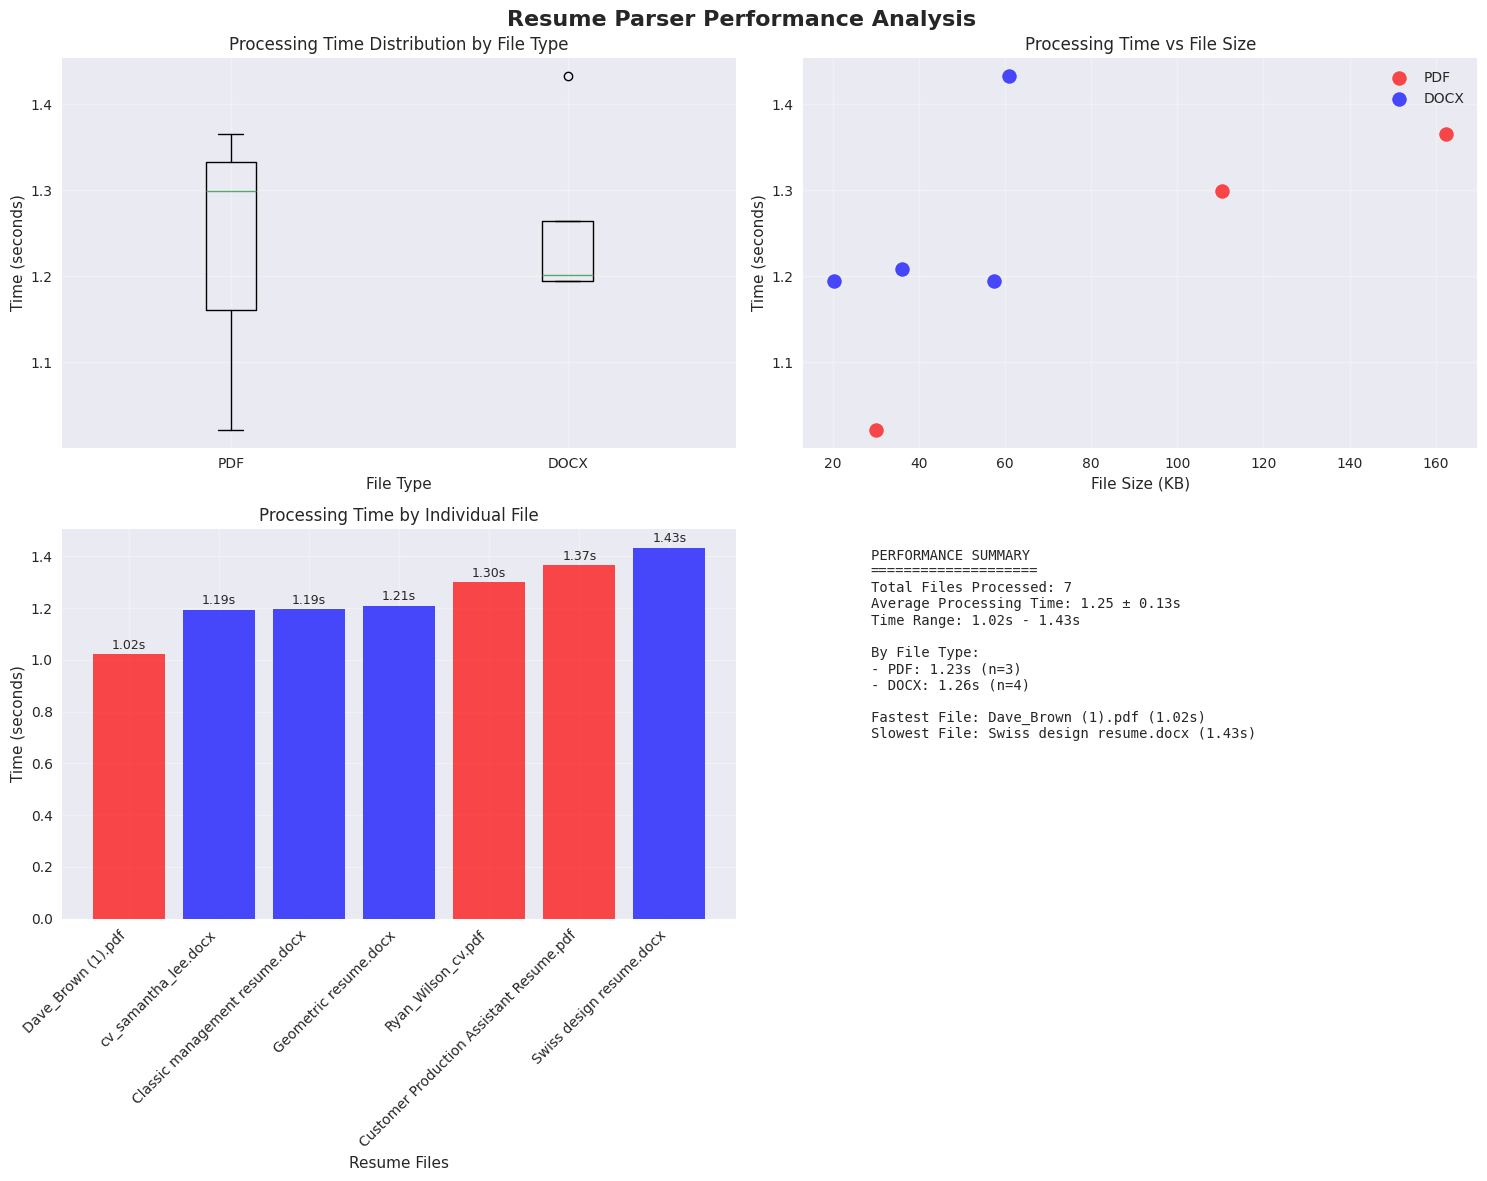

In [14]:
import matplotlib.pyplot as plt

def create_performance_visualizations(performance_df: pl.DataFrame):
    """
    Create comprehensive visualizations for performance metrics using Polars DataFrame
    
    Args:
        performance_df: Polars DataFrame with performance metrics
    """
    # Convert to pandas for visualization (since matplotlib/seaborn work better with pandas)
    # But first, let's make sure we can work directly with Polars where possible
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Resume Parser Performance Analysis', fontsize=16, fontweight='bold')
    
    # Extract data from Polars DataFrame
    file_types = performance_df['file_type'].unique().to_list()
    filenames = performance_df['filename'].to_list()
    avg_times = performance_df['avg_processing_time'].to_list()
    file_sizes = performance_df['file_size_kb'].to_list()
    
    # 1. Processing Time by File Type (Box Plot)
    axes[0, 0].clear()
    
    # Group by file type and extract times
    file_type_data = []
    for file_type in file_types:
        type_times = performance_df.filter(pl.col('file_type') == file_type)['avg_processing_time'].to_list()
        file_type_data.append(type_times)
    
    box_plot = axes[0, 0].boxplot(file_type_data, labels=file_types)
    axes[0, 0].set_title('Processing Time Distribution by File Type')
    axes[0, 0].set_ylabel('Time (seconds)')
    axes[0, 0].set_xlabel('File Type')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Processing Time vs File Size (Scatter Plot)
    axes[0, 1].clear()
    colors = {'PDF': 'red', 'DOCX': 'blue'}
    
    for file_type in file_types:
        subset = performance_df.filter(pl.col('file_type') == file_type)
        if len(subset) > 0:
            sizes = subset['file_size_kb'].to_list()
            times = subset['avg_processing_time'].to_list()
            axes[0, 1].scatter(sizes, times, 
                              c=colors.get(file_type, 'green'), 
                              label=file_type, alpha=0.7, s=100)
    
    axes[0, 1].set_title('Processing Time vs File Size')
    axes[0, 1].set_ylabel('Time (seconds)')
    axes[0, 1].set_xlabel('File Size (KB)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Individual File Performance (Bar Chart)
    axes[1, 0].clear()
    
    # Sort by processing time
    sorted_df = performance_df.sort('avg_processing_time')
    sorted_filenames = sorted_df['filename'].to_list()
    sorted_times = sorted_df['avg_processing_time'].to_list()
    sorted_types = sorted_df['file_type'].to_list()
    
    x_positions = range(len(sorted_df))
    bars = axes[1, 0].bar(x_positions, sorted_times,
                         color=['red' if ft == 'PDF' else 'blue' for ft in sorted_types],
                         alpha=0.7)
    
    axes[1, 0].set_title('Processing Time by Individual File')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].set_xlabel('Resume Files')
    axes[1, 0].set_xticks(x_positions)
    axes[1, 0].set_xticklabels(sorted_filenames, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.2f}s', ha='center', va='bottom', fontsize=9)
    
    # 4. Performance Summary Statistics
    axes[1, 1].clear()
    axes[1, 1].axis('off')
    
    # Calculate statistics using Polars
    avg_time = performance_df['avg_processing_time'].mean()
    std_time = performance_df['avg_processing_time'].std()
    min_time = performance_df['avg_processing_time'].min()
    max_time = performance_df['avg_processing_time'].max()
    
    summary_text = [
        "PERFORMANCE SUMMARY",
        "=" * 20,
        f"Total Files Processed: {len(performance_df)}",
        f"Average Processing Time: {avg_time:.2f} ± {std_time:.2f}s",
        f"Time Range: {min_time:.2f}s - {max_time:.2f}s",
        "",
        "By File Type:"
    ]
    
    for file_type in file_types:
        type_df = performance_df.filter(pl.col('file_type') == file_type)
        if len(type_df) > 0:
            type_avg = type_df['avg_processing_time'].mean()
            summary_text.append(f"- {file_type}: {type_avg:.2f}s (n={len(type_df)})")
    
    min_file = performance_df.filter(pl.col('avg_processing_time') == min_time)['filename'].to_list()[0]
    max_file = performance_df.filter(pl.col('avg_processing_time') == max_time)['filename'].to_list()[0]
    
    summary_text.extend([
        "",
        f"Fastest File: {min_file} ({min_time:.2f}s)",
        f"Slowest File: {max_file} ({max_time:.2f}s)"
    ])
    
    axes[1, 1].text(0.1, 0.95, '\n'.join(summary_text), transform=axes[1, 1].transAxes,
                   fontfamily='monospace', verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate the visualizations
performance_viz = create_performance_visualizations(performance_df)
